# Compare models

This notebook supports following features:
- Plot metric vs. parameter value, per each pair of parameter and metric - scatter plot,
  - Color by parameter or another metric,
  - Support logarithmic scale,
- Plot aggregated metric vs. parameter, group by another parameter or metric value,
    - Visulize variance
- Plot 3D scatter plots for two parameters and metric, support coloring by another parameter, etc.


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from specvae import utils

In [2]:
def load_experiment_from_path(filepath):
    return pd.read_csv(filepath, index_col=0)

def load_experiment(dataset, experiment_name, base_path=None):
    if base_path is None:
        filepath = utils.get_project_path() / '.model' / dataset / experiment_name / 'experiment.csv'
    else:
        filepath = base_path / dataset / experiment_name / 'experiment.csv'
    return load_experiment_from_path(filepath)


In [3]:
df = load_experiment('MoNA', 'clf_nextron')
df

,name,target_column,target_column_id,dataset,full_model_name,layer_config,input_columns,class_subset,param_n_classes,param_dropout,...,m_valid_balanced_accuracy_score,m_valid_recall_score_macro,m_valid_precision_score_macro,m_valid_f1_score_macro,m_test_loss,m_test_accuracy_score,m_test_balanced_accuracy_score,m_test_recall_score_macro,m_test_precision_score_macro,m_test_f1_score_macro
0,clf,ionization_mode,ionization_mode_id,MoNA,clf_741-494-185-1_01 (04-12-2021_14-11-37),"[741, 494, 185]","['spectrum', 'collision_energy', 'total_exact_...",[],2,0.0,...,0.977517,0.977517,0.977324,0.977170,0.111487,0.955842,0.955742,0.955742,0.957767,0.955391
1,clf,ionization_mode,ionization_mode_id,MoNA,clf_741-494-185-1_01 (04-12-2021_14-30-21),"[741, 494, 185]","['spectrum', 'collision_energy', 'total_exact_...",[],2,0.0,...,0.960679,0.960679,0.962511,0.960699,0.068274,0.967986,0.968284,0.968284,0.969047,0.967754
2,clf,ionization_mode,ionization_mode_id,MoNA,clf_741-494-185-1_01 (04-12-2021_14-49-51),"[741, 494, 185]","['spectrum', 'collision_energy', 'total_exact_...",[],2,0.0,...,0.941955,0.941955,0.943256,0.940681,0.179670,0.945907,0.945740,0.945740,0.947354,0.945480
3,clf,ionization_mode,ionization_mode_id,MoNA,clf_741-494-185-1_01 (04-12-2021_15-08-44),"[741, 494, 185]","['spectrum', 'collision_energy', 'total_exact_...",[],2,0.0,...,0.976897,0.976897,0.977100,0.976781,0.100512,0.955078,0.955201,0.955201,0.957496,0.954687
4,clf,ionization_mode,ionization_mode_id,MoNA,clf_741-494-185-1_01 (04-12-2021_15-29-16),"[741, 494, 185]","['spectrum', 'collision_energy', 'total_exact_...",[],2,0.0,...,0.976761,0.976761,0.977281,0.976755,0.182116,0.949474,0.949405,0.949405,0.952707,0.948990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,clf,instrument,instrument_id,MoNA,clf_518-345-129-12_01 (05-12-2021_15-55-18),"[518, 345, 129]","['spectrum', 'collision_energy', 'total_exact_...","[0, 129, 130, 155, 161, 133, 122, 157, 136, 11...",12,0.0,...,0.817409,0.817409,0.833303,0.805263,0.456430,0.798270,0.800722,0.800722,0.806686,0.789579
101,clf,instrument,instrument_id,MoNA,clf_518-345-129-12_01 (05-12-2021_16-06-02),"[518, 345, 129]","['spectrum', 'collision_energy', 'total_exact_...","[0, 129, 130, 155, 161, 133, 122, 157, 136, 11...",12,0.0,...,0.839814,0.839814,0.851207,0.833674,0.443888,0.834248,0.836189,0.836189,0.840575,0.830266
102,clf,instrument,instrument_id,MoNA,clf_518-345-129-12_01 (05-12-2021_16-17-09),"[518, 345, 129]","['spectrum', 'collision_energy', 'total_exact_...","[0, 129, 130, 155, 161, 133, 122, 157, 136, 11...",12,0.0,...,0.856708,0.856708,0.859129,0.849727,0.404199,0.837062,0.836327,0.836327,0.838741,0.828934
103,clf,instrument,instrument_id,MoNA,clf_518-345-129-12_01 (05-12-2021_16-28-26),"[518, 345, 129]","['spectrum', 'collision_energy', 'total_exact_...","[0, 129, 130, 155, 161, 133, 122, 157, 136, 11...",12,0.0,...,0.816889,0.816889,0.822725,0.808308,0.447361,0.819624,0.816864,0.816864,0.819500,0.809498


In [8]:
columns = list(df.columns)
params = list(filter(lambda x: x.startswith('param_'), columns))
values = list(filter(lambda x: x.startswith('m_'), columns))
others = list(filter(lambda x: not x.startswith('m_') and not x.startswith('param_'), columns))
# Separate by split:
train_values = list(filter(lambda x: x.startswith('m_train_'), columns))
valid_values = list(filter(lambda x: x.startswith('m_valid_'), columns))
test_values = list(filter(lambda x: x.startswith('m_test_'), columns))

In [9]:
def plot_param_and_value(param_name, value_name, color_name=None, hover_data=None, log_x=False):
    if param_name not in params and 'param_' + param_name not in params:
        raise ValueError('Parameter \'%s\' not found' % param_name)
    if value_name not in values and 'm_' + value_name not in values:
        raise ValueError('Value \'%s\' not found' % value_name)
    if color_name is not None and 'param_' + color_name not in columns and 'm_' + color_name not in columns and color_name not in columns:
        raise ValueError('Value or parameter \'%s\' not found in columns' % color_name)

    plot_param_name = param_name if param_name in params else 'param_' + param_name
    plot_value_name = value_name if value_name in values else 'm_' + value_name
    plot_color_name = None
    if color_name is not None:
        plot_color_name = 'param_' + color_name if 'param_' + color_name in columns else 'm_' + color_name
        plot_color_name = color_name if color_name in columns else plot_color_name

    fig = px.scatter(df, x=plot_param_name, y=plot_value_name, color=plot_color_name, hover_data=hover_data, log_x=log_x)
    fig.show()


In [10]:
def plot3d_param_and_value(param_name1, param_name2, value_name, color_name=None, hover_data=None, log_x=False, width=600, height=600):
    if param_name1 not in params and 'param_' + param_name1 not in params:
        raise ValueError('Parameter \'%s\' not found' % param_name1)
    if param_name2 not in params and 'param_' + param_name2 not in params:
        raise ValueError('Parameter \'%s\' not found' % param_name2)
    if value_name not in values and 'm_' + value_name not in values:
        raise ValueError('Value \'%s\' not found' % value_name)
    if color_name is not None and 'param_' + color_name not in columns and 'm_' + color_name not in columns and color_name not in columns:
        raise ValueError('Value or parameter \'%s\' not found in columns' % color_name)

    plot_param_name1 = param_name1 if param_name1 in params else 'param_' + param_name1
    plot_param_name2 = param_name2 if param_name2 in params else 'param_' + param_name2
    plot_value_name = value_name if value_name in values else 'm_' + value_name
    plot_color_name = None
    if color_name is not None:
        plot_color_name = 'param_' + color_name if 'param_' + color_name in columns else 'm_' + color_name
        plot_color_name = color_name if color_name in columns else plot_color_name

    fig = px.scatter_3d(
        df, x=plot_param_name1, y=plot_param_name2, z=plot_value_name, 
        color=plot_color_name, hover_data=hover_data, log_x=log_x,
        width=width, height=height)
    fig.show()


In [7]:
plot_param_and_value('param_min_intensity', 'm_train_cos_sim', 'train_loss', hover_data=params)

ValueError: Value 'm_train_cos_sim' not found

In [ ]:
plot3d_param_and_value('param_min_intensity', 'max_num_peaks', 'm_train_cos_sim', 'train_loss', hover_data=params, width=800, height=800)

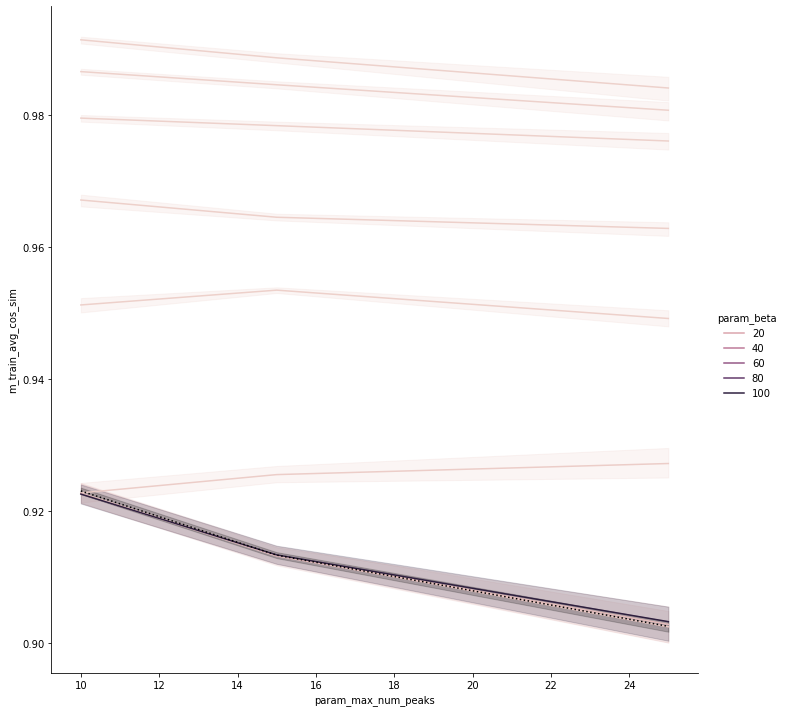

In [ ]:
rp = sns.relplot(data=df, x="param_max_num_peaks", y="m_train_cos_sim",
    hue="param_beta", kind="line", markers=True, height=10)
rp.map(sns.lineplot, 'param_max_num_peaks', 'm_train_avg_cos_sim', linestyle=':', color='black')

## Rescale intensity

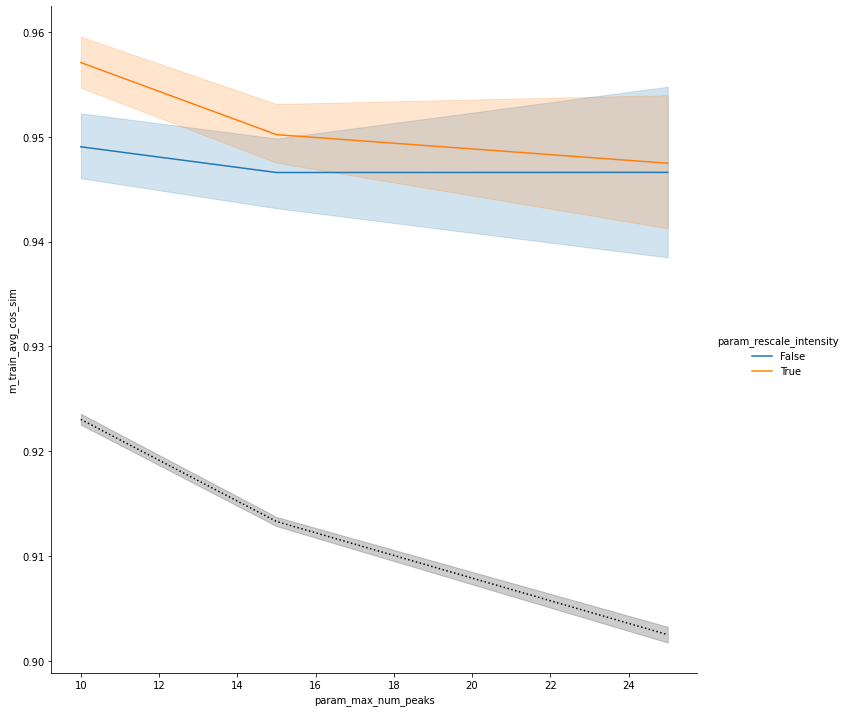

In [ ]:
rp = sns.relplot(data=df, x="param_max_num_peaks", y="m_train_cos_sim",
    hue="param_rescale_intensity", kind="line", markers=True, height=10)
rp.map(sns.lineplot, 'param_max_num_peaks', 'm_train_avg_cos_sim', linestyle=':', color='black', label='avg')

- How beta parameter impacts reconstruction metrics and KL divergence.
    - Include baseline values for reconstruction metrics.
- How rescale_intesity parameter (normalizing values to range min-max) impacts reconstruction metrics and KL divergnece.
- How max_num_peaks impacts reconstruction metrics and KL divergence.
- How min_intensity impacts reconstruction metrics and KL divergence.

<AxesSubplot:xlabel='param_max_num_peaks', ylabel='m_train_recon'>

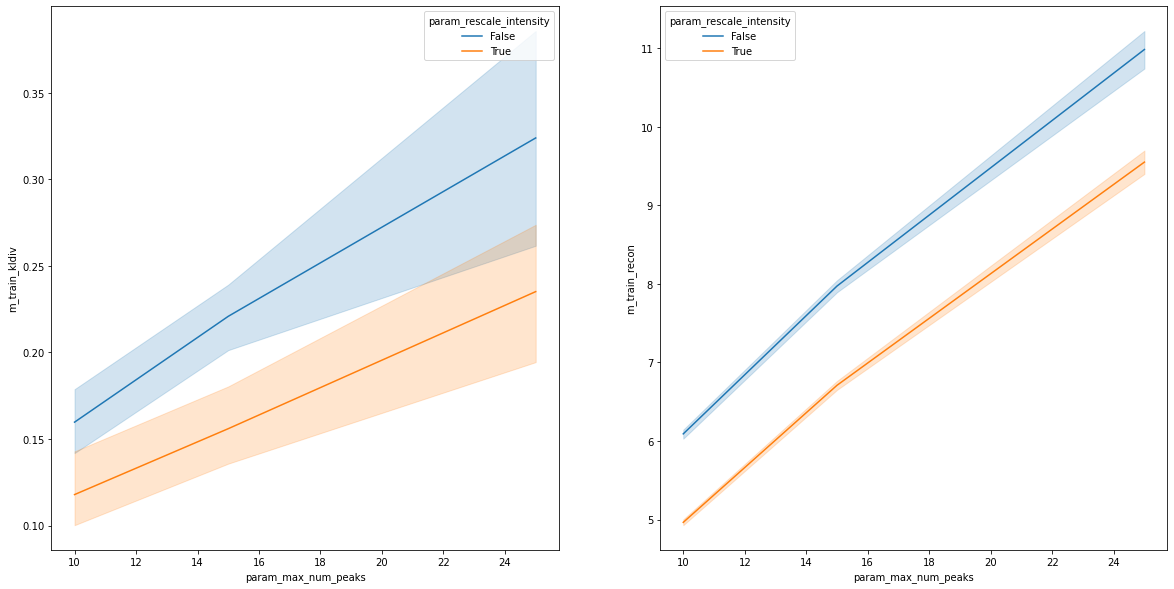

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(data=df, x="param_max_num_peaks", y="m_train_kldiv",
    hue="param_rescale_intensity", markers=True, ax=axs[0])
sns.lineplot(data=df, x="param_max_num_peaks", y="m_train_recon",
    hue="param_rescale_intensity", markers=True, ax=axs[1])

## Max num peaks

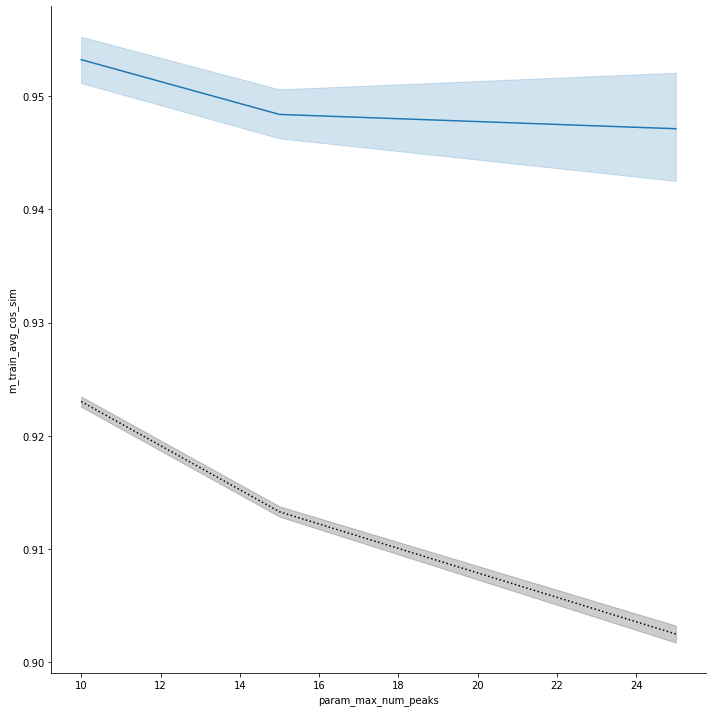

In [ ]:
rp = sns.relplot(data=df, x="param_max_num_peaks", y="m_train_cos_sim", kind="line", markers=True, height=10)
rp.map(sns.lineplot, 'param_max_num_peaks', 'm_train_avg_cos_sim', linestyle=':', color='black')

<AxesSubplot:xlabel='param_max_num_peaks', ylabel='m_train_recon'>

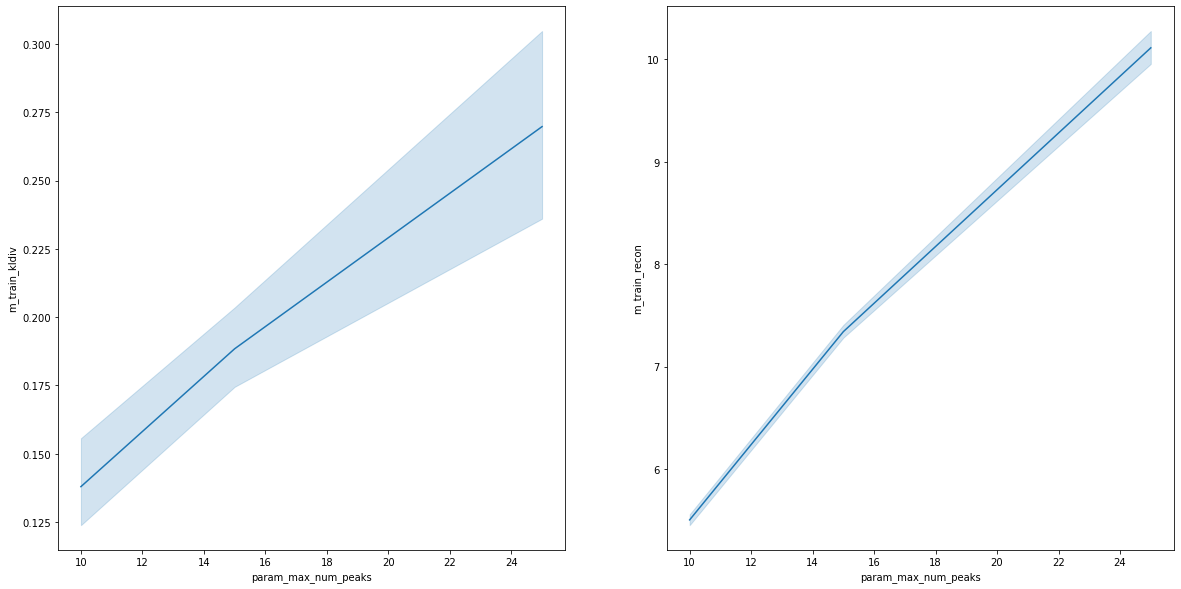

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(data=df, x="param_max_num_peaks", y="m_train_kldiv", markers=True, ax=axs[0])
sns.lineplot(data=df, x="param_max_num_peaks", y="m_train_recon", markers=True, ax=axs[1])

## Min intensity

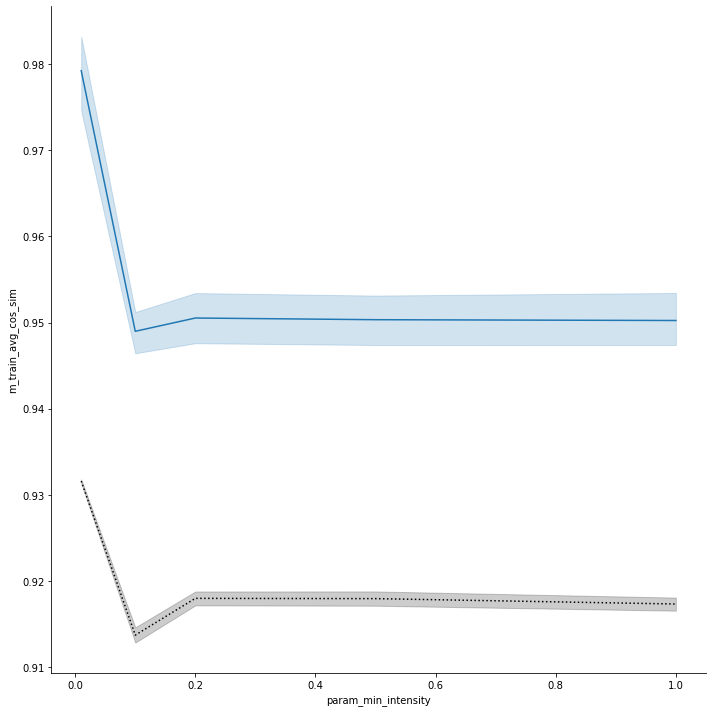

In [ ]:
rp = sns.relplot(data=df, x="param_min_intensity", y="m_train_cos_sim", kind="line", markers=True, height=10)
rp.map(sns.lineplot, 'param_min_intensity', 'm_train_avg_cos_sim', linestyle=':', color='black')